In [171]:
from PIL import Image
from skimage import measure
from skimage import color
import numpy as np 
import pandas as pd 
import os
import sys
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pickle
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=34)
from pathlib import Path
from skimage import exposure
import matplotlib
sns.set(font_scale=2)
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [174]:
from config import *
import my_io as io

In [175]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split('\\')[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [176]:
conditions = ['Disease']*6 + ['Healthy']*6

# Get stats

In [177]:
df = pd.DataFrame()
df_exp = pd.DataFrame()
for n, dataset in enumerate(datasets):
    markers = []
    imgs = []    
    masks = []

    for (dirpath, dirnames, filenames) in os.walk(data_raw / dataset):
        for name in sorted(filenames):
            if 'tiff' in name and dataset in name:
                img = cv2.imread(os.path.join(dirpath,name),flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))
                imgs.append(img)
                markers.append(name.split('_')[1].split('.')[0])
                p2, p98 = np.percentile(img, (2, 98))
                img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
                blur = cv2.GaussianBlur(img_rescale, (25,25),0)
                ret,th = cv2.threshold(blur,60,255,cv2.THRESH_BINARY)
                masks.append(th)

#     for (dirpath, dirnames, filenames) in os.walk(data_mask / dataset):
#         for name in sorted(filenames):
#             if 'tiff' in name and dataset in name:        
#                 img = cv2.imread(os.path.join(dirpath,name),0)
#                 masks.append(img)
                
    # Read cell mask image 
    for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
        for name in sorted(filenames):
            if  'tiff' in name and dataset in name:
                cell_mask = np.array(Image.open(os.path.join(dirpath,name)))
            
    max_cell = len(np.unique(cell_mask))
    
    # Read mean intensity of marker in cell 
    marker_area = {}
    marker_exp = {}
    for idx, marker in enumerate(markers):
        if marker in ['DNA1', 'DNA2', 'Histone3']:
            continue
        mask_marker = cv2.bitwise_and(cell_mask,cell_mask, mask=masks[idx])
        cell_count = len(np.unique(mask_marker)) / max_cell
        marker_area[marker] = [cell_count]
        prop = measure.regionprops_table(mask_marker, imgs[idx], properties=['area', 'mean_intensity'])
        marker_exp[marker] = [np.sum(prop['mean_intensity']*prop['area'])]
        
        
    df_temp = pd.DataFrame.from_dict(marker_area)
    df_temp['ROI'] = dataset
    df = df.append(df_temp, ignore_index=True)
    
    df_temp = pd.DataFrame.from_dict(marker_exp)
    df_temp['ROI'] = dataset
    df_exp = df_exp.append(df_temp, ignore_index=True)

df = df.drop(columns=['CD44', 'H3K9me3', 'MHCII'])
df_exp = df_exp.drop(columns=['CD44', 'H3K9me3', 'MHCII'])

In [178]:
df.set_index('ROI', inplace=True)
df.head()

,CD20,CD3,CD4,CD45RO,CD68,CD8a,Col1,Ecadherin,FoxP3,GranzymeB,Ki67,PD1,PDL1,Pankeratin,SMA,Vimentin
ROI,,,,,,,,,,,,,,,,
DT1,0.421736,0.438112,0.447581,0.885671,0.675929,0.353271,0.105588,0.862607,0.005076,0.242121,0.199921,0.012691,0.223404,0.101638,0.307672,0.597488
DT2,0.475258,0.612070,0.394569,0.974638,0.696278,0.330545,0.206170,0.915372,0.191674,0.289758,0.190103,0.031072,0.832824,0.137587,0.164431,0.771788
DT3,0.530255,0.475413,0.342595,0.925820,0.866683,0.372912,0.452599,0.940364,0.300907,0.331100,0.247652,0.091860,0.642968,0.331688,0.385923,0.715437
DT4,0.585478,0.665994,0.600570,0.975161,0.660704,0.393026,0.088636,0.922616,0.039205,0.379421,0.205155,0.022168,0.760823,0.148541,0.707447,0.850786
DT5,0.557386,0.818699,0.639755,0.993189,0.556681,0.600162,0.323249,0.961851,0.290587,0.263394,0.178532,0.000912,0.829105,0.078722,0.322905,0.974441


In [179]:
scaler = MinMaxScaler()
df_exp.set_index('ROI', inplace=True)
scaled_rows = scaler.fit_transform(df_exp.T).T
df_exp = pd.DataFrame(scaled_rows, index=df_exp.index, columns=df_exp.columns)
df_exp.head()

,CD20,CD3,CD4,CD45RO,CD68,CD8a,Col1,Ecadherin,FoxP3,GranzymeB,Ki67,PD1,PDL1,Pankeratin,SMA,Vimentin
ROI,,,,,,,,,,,,,,,,
DT1,0.196061,0.288044,0.292289,1.000000,0.420770,0.162329,0.148822,0.823448,0.000000,0.194014,0.074011,0.001831,0.006678,0.082971,0.144342,0.422691
DT2,0.312820,0.313375,0.182497,1.000000,0.504639,0.107831,0.150740,0.739971,0.029662,0.188685,0.076017,0.000000,0.142436,0.098866,0.061584,0.600060
DT3,0.386084,0.318985,0.188687,0.938276,0.662237,0.171261,0.286458,1.000000,0.111368,0.239100,0.073463,0.000000,0.146366,0.260627,0.130517,0.659867
DT4,0.302327,0.357034,0.292347,1.000000,0.300784,0.149278,0.052565,0.775355,0.000669,0.123471,0.072202,0.000000,0.040434,0.085648,0.323272,0.610784
DT5,0.240455,0.570756,0.422906,1.000000,0.186009,0.243317,0.144318,0.570545,0.066559,0.071286,0.050085,0.000000,0.165948,0.030063,0.083005,0.820793


# Visualization

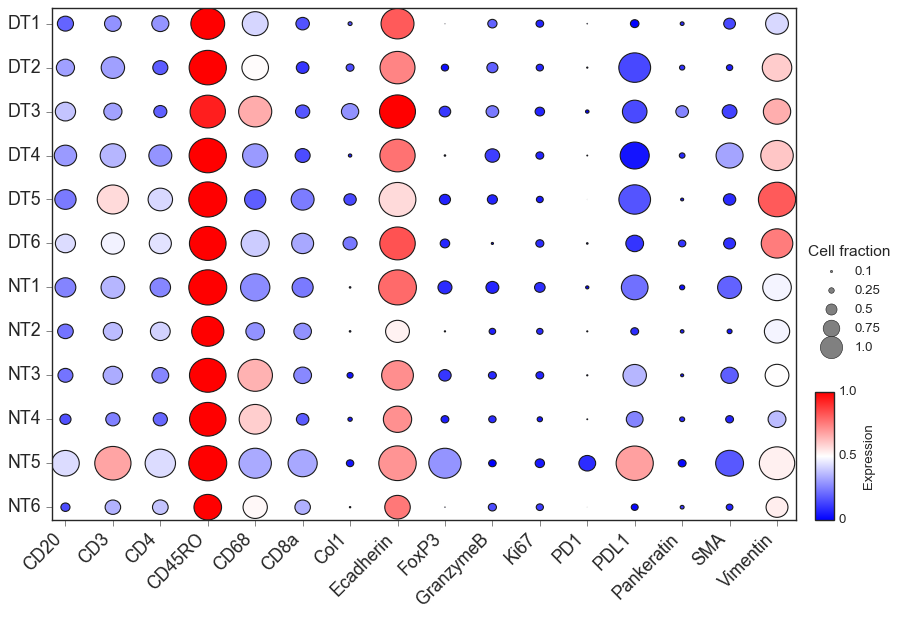

In [180]:
from matplotlib.collections import PatchCollection
plt.style.use('classic')
plt.style.use('seaborn-white')

xlabels = df.columns.tolist()
ylabels = df.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = df.values
c = df_exp.values

# Get size and color 
R = s/s.max()/2.5
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")

# Plot image
fig, ax = plt.subplots(figsize=(12,8))
ax.add_collection(col)
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.tick_params(which='major', length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
cbar = fig.colorbar(col, cax = fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1.0'])
cbar.set_label('Expression')

# Size legend
h = [ax.plot([],[], color="gray", marker="o", ms=i*2, ls="", label=i/10)[0] for i in [1, 2.5, 5, 7.5, 10]]
leg = ax.legend(handles=h, loc='lower left', bbox_to_anchor=(1.0, 0.3, 0.02, 0.4),  fontsize='medium')
leg.set_title('Cell fraction',prop={'size':14})

plt.show()

In [181]:
df_subset = df.loc[['DT1', 'DT2', 'DT3', 'NT1', 'NT2', 'NT3']]
df_subset_exp = df_exp.loc[['DT1', 'DT2', 'DT3', 'NT1', 'NT2', 'NT3']]

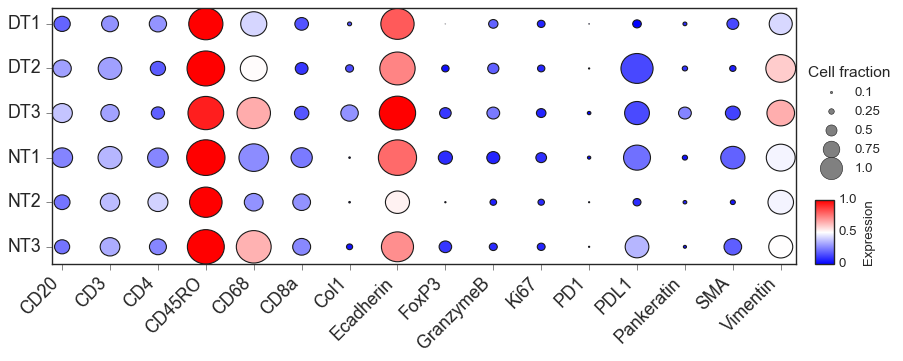

In [182]:
from matplotlib.collections import PatchCollection
plt.style.use('classic')
plt.style.use('seaborn-white')

xlabels = df_subset.columns.tolist()
ylabels = df_subset.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = df_subset.values
c = df_subset_exp.values

# Get size and color 
R = s/s.max()/2.5
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")

# Plot image
fig, ax = plt.subplots(figsize=(12,4))
ax.add_collection(col)
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.tick_params(which='major', length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
cbar = fig.colorbar(col, cax = fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1.0'])
cbar.set_label('Expression')

# Size legend
h = [ax.plot([],[], color="gray", marker="o", ms=i*2, ls="", label=i/10)[0] for i in [1, 2.5, 5, 7.5, 10]]
leg = ax.legend(handles=h, loc='lower left', bbox_to_anchor=(1.0, 0.3, 0.02, 0.4),  fontsize='medium')
leg.set_title('Cell fraction',prop={'size':14})

plt.show()

# Hierchichal clustering 

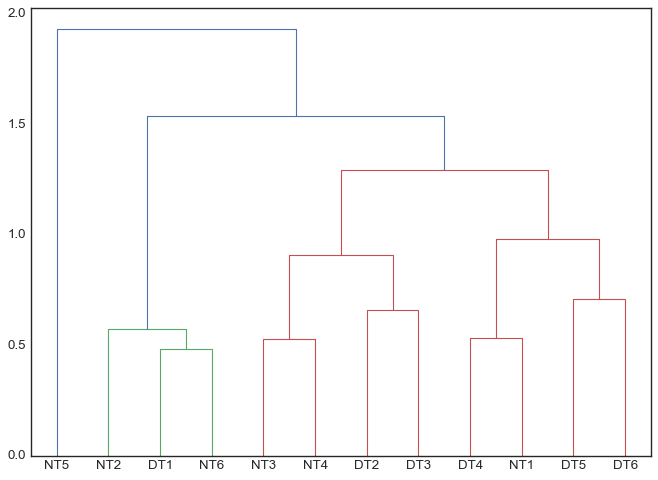

In [196]:
from scipy.cluster.hierarchy import dendrogram, linkage

df_joined = df.join(df_exp, lsuffix='_area', rsuffix='_exp')

linked = linkage(df_joined, 'ward')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=df_joined.index.tolist(),
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

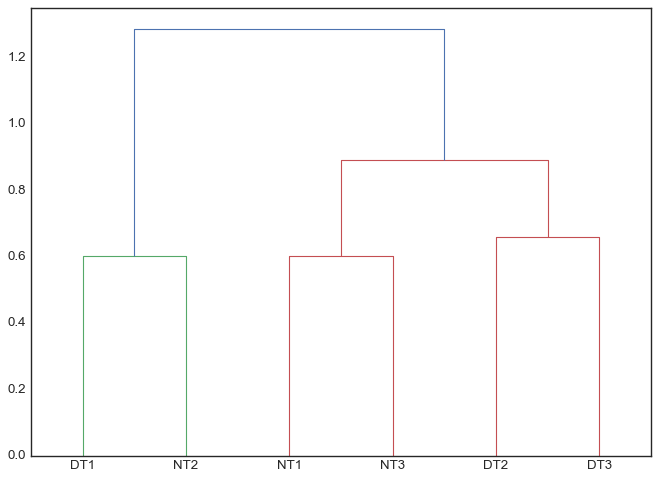

In [194]:
from scipy.cluster.hierarchy import dendrogram, linkage

df_subset_joined = df_subset.join(df_subset_exp, lsuffix='_area', rsuffix='_exp')

linked = linkage(df_subset_joined, 'ward')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=df_subset_joined.index.tolist(),
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

# ROI statistics

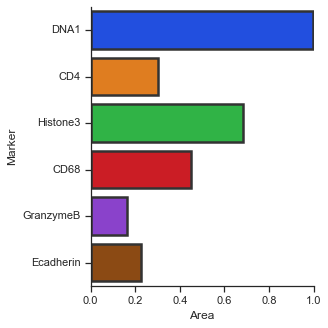

In [87]:
dataset = 'DT3'
marker_list = ['DNA1', 'CD4', 'Histone3', 'CD68', 'GranzymeB', 'Ecadherin']

sns.set_style("ticks")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize= (4,5))
df_area = pd.DataFrame(df.loc[dataset, marker_list])
df_area.reset_index(inplace=True)
df_area.columns=['Marker', 'Area']
ax = sns.barplot(x = 'Area', y='Marker', data=df_area, linewidth=2.5, edgecolor=".2", palette="bright")
ax.set_xlim(0,1.0)
sns.despine()

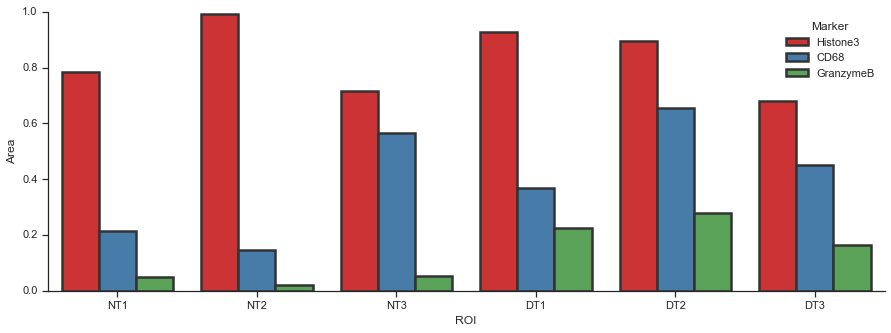

In [80]:
datasets = ['NT1', 'NT2', 'NT3','DT1', 'DT2', 'DT3']
marker_list = [ 'Histone3', 'CD68', 'GranzymeB']

sns.set_style("ticks")
sns.set_context("notebook")
df_area = pd.DataFrame(df.loc[datasets, marker_list])
df_area.reset_index(inplace=True)
df_area = df_area.melt(id_vars=['ROI'],var_name='Marker', value_name='Area')
fig, ax = plt.subplots(figsize= (15,5))
ax = sns.barplot(x = 'ROI', y='Area', hue='Marker', data=df_area, linewidth=2.5, edgecolor=".2", palette="Set1")
sns.despine()

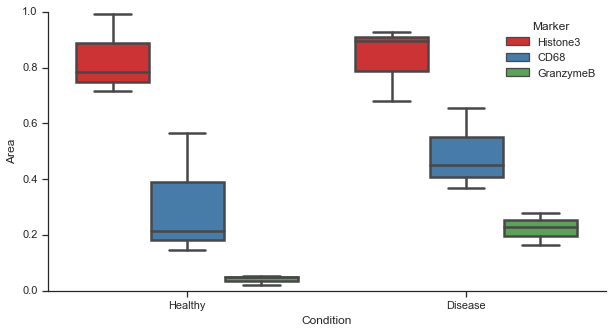

In [90]:
datasets = ['NT1', 'NT2', 'NT3','DT1', 'DT2', 'DT3']
marker_list = [ 'Histone3', 'CD68', 'GranzymeB']
condition = ['Healthy'] * 3 + ['Disease'] * 3

sns.set_style("ticks")
sns.set_context("notebook")
df_area = pd.DataFrame(df.loc[datasets, marker_list])
df_area['Condition'] = condition
df_area = df_area.melt(id_vars=['Condition'],var_name='Marker', value_name='Area')

fig, ax = plt.subplots(figsize= (10,5))
ax = sns.boxplot(x = 'Condition', y='Area', hue='Marker', linewidth=2.5, data=df_area, palette="Set1")
sns.despine()